In [1]:
import transformers

print(transformers.__version__)

4.15.0


# Train a language model

## Causal Language modeling

In [2]:
def splitTolenWords(text, nwords):
    words = text.split(" ")
    count = int(len(words)/nwords)
    sentences = [" ".join(words[(i*nwords):((i+1)*nwords)]) for i in range(count)]
    return(sentences)

In [3]:
with open("data_splits/trumpGeneratorTextTrain.txt", encoding = "utf-8") as f:
    gentrain = splitTolenWords(f.read(), 100)
    
with open("data_splits/trumpGeneratorTextValid.txt", encoding = "utf-8") as f:
    genvalid = splitTolenWords(f.read(), 100)
    
with open("data_splits/trumpGeneratorTextTrain.txt", encoding = "utf-8") as f:
    wholetext = f.read()

In [4]:
from datasets import Dataset
import datasets
datasettrain = Dataset.from_dict({"train": gentrain})
datasetvalid = Dataset.from_dict({"train": genvalid})

dataset = datasets.dataset_dict.DatasetDict({"train": datasettrain, "test": datasetvalid})

In [5]:
model_checkpoint = "gpt2"
tokenizer_checkpoint = 'gpt2'

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(tokenizer_checkpoint)

def tokenize_function(examples):
    return tokenizer(examples["train"])

tokenized_datasets = dataset.map(
    tokenize_function, batched=True, num_proc=1, remove_columns=["train"]
)

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [7]:
tokenizer

PreTrainedTokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_len=1024, is_fast=True, padding_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'})

In [7]:
#block_size = tokenizer.model_max_length
block_size = 200

def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc=1,
)

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [8]:
tokenizer.decode(lm_datasets["train"][3]["input_ids"])

" everything we had, it was depleted.  Now we've rebuilt our military like never before.  And all But if you want to vote for a weak candidate tomorrow, go ahead.  Pick one.  Pick the weakest one you think, I don't know who it is.  We are a big party with big ideas for the future.  Very big.  We become a big party and an open-minded party and we're the party that people like.  We're the hot party and we're the party with all the enthusiasm.  We are fighting for school choice because no parent should ever be forced to send their child to a failing government school.  Right?word.  That's the word.  I stand before you today to declare the silent majority is stronger than ever before.  Five months from now, we're going to defeat sleepy Joe Biden.  Boy, does he get a pass from these people, huh? We're going to stop the radical left"

Now that the data has been cleaned, we're ready to instantiate our `Model`. First we create the model using the same config as our checkpoint, but initialized with random weights:

In [11]:
batch_size = 1
num_epochs = 150

In [12]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors='tf')

train_set = lm_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator
)
validation_set = lm_datasets["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator
)

In [9]:
from transformers import AutoConfig, TFAutoModelForCausalLM

In [13]:
from transformers import create_optimizer
import tensorflow as tf

batches_per_epoch = len(lm_datasets["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(
    init_lr=0.00001, 
    num_warmup_steps=0, 
    num_train_steps=total_train_steps
)

from transformers import AutoConfig, TFAutoModelForCausalLM

config = AutoConfig.from_pretrained(model_checkpoint)
model = TFAutoModelForCausalLM.from_config(config)

model.compile(optimizer = optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as the 'labels' key of the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


In [14]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
import spacy
import en_core_web_sm


class SaveModelPrintMetricsCallback(tf.keras.callbacks.Callback):
    """
    Save best model if vall loss is smaller, used for Transformers package
  """

    def __init__(self, name, validation_data, tokenizer, metric = "loss", every_n = 10):
        super(SaveModelPrintMetricsCallback, self).__init__()
        self.name = name
        self.metric = metric
        self.epoch_saved = 0
        self.every_n = every_n
        self.validation_data = [i.split(" ") for i in validation_data]
        self.tokenizer = tokenizer
        self.bleu1 = []
        self.bleu2 = []
        self.bleu3 = []
        self.bleu4 = []
        
        
    def unnameTextWithM(self, text):
        nlp = en_core_web_sm.load()
        doc = nlp(text)
        text = text
        for ent in reversed(doc.ents):
            text = text[:ent.start_char] + "<M>" + text[ent.end_char:] 
        return text.split(" ")


    def on_train_begin(self, logs=None):
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        outputs = self.model.generate(
                        max_length=130, 
                        do_sample=True,
                        temperature=0.7,
                        top_p = 0.8
                        )
        generated = self.unnameTextWithM(self.tokenizer.decode(outputs[0]))
        
        blue1 = sentence_bleu(self.validation_data, generated,weights = (1,0,0,0))
        blue2 = sentence_bleu(self.validation_data, generated,weights = (0,1,0,0))
        blue3 = sentence_bleu(self.validation_data, generated,weights = (0,0,1,0))
        blue4 = sentence_bleu(self.validation_data, generated,weights = (0,0,0,1))
        

        
        print("interval evaluation - epoch: {:d} - blue1: {:.6f}, blue2: {:.6f}, blue3: {:.6f}, blue4: {:.6f},".format(epoch, blue1, blue2, blue3, blue4))
                
        current = logs.get(self.metric)
        if np.less(current, self.best):
            self.best = current
            # Record the best weights if current results is better (less).
            self.model.save_pretrained(self.name + " " + str(epoch))
        elif (self.epoch_saved + self.every_n - 1) < epoch:
            self.model.save_pretrained(self.name + " " + str(epoch))
            self.epoch_saved = epoch
            
        self.bleu1.append(blue1)
        self.bleu2.append(blue2)
        self.bleu3.append(blue3)
        self.bleu4.append(blue4)
            


Now we can train our model. We can also add a callback to sync up our model with the Hub - this allows us to resume training from other machines and even test the model's inference quality midway through training! Make sure to change the `username` if you do. If you don't want to do this, simply remove the callbacks argument in the call to `fit()`.

In [15]:
model_checkpoint_callback = SaveModelPrintMetricsCallback(name = "generators/gpt2-small/GPT_2", metric = "val_loss", every_n = 10, validation_data = genvalid, tokenizer = tokenizer)

callbacks = [
    model_checkpoint_callback,
]



In [16]:


history = model.fit(train_set, validation_data=validation_set, epochs=num_epochs, callbacks = callbacks)


Epoch 1/150
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
1759/1759 [==============================] - 497s 274ms/step - loss: 6.0927 - val_loss: 5.0877


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 0 - blue1: 0.894231, blue2: 0.689320, blue3: 0.392157, blue4: 0.118812,
Epoch 2/150
1759/1759 [==============================] - 493s 280ms/step - loss: 4.9364 - val_loss: 4.7482


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 1 - blue1: 0.903846, blue2: 0.805825, blue3: 0.588235, blue4: 0.326733,
Epoch 3/150
1759/1759 [==============================] - 497s 283ms/step - loss: 4.6583 - val_loss: 4.5734


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 2 - blue1: 0.838360, blue2: 0.675882, blue3: 0.387503, blue4: 0.164952,
Epoch 4/150
1759/1759 [==============================] - 493s 280ms/step - loss: 4.4775 - val_loss: 4.4679


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 3 - blue1: 0.970297, blue2: 0.840000, blue3: 0.535354, blue4: 0.214286,
Epoch 5/150
1759/1759 [==============================] - 489s 278ms/step - loss: 4.3397 - val_loss: 4.3968


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 4 - blue1: 0.877358, blue2: 0.761905, blue3: 0.567308, blue4: 0.291262,
Epoch 6/150
1759/1759 [==============================] - 486s 276ms/step - loss: 4.2276 - val_loss: 4.3508


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 5 - blue1: 0.940000, blue2: 0.828283, blue3: 0.520408, blue4: 0.257732,
Epoch 7/150
1759/1759 [==============================] - 480s 273ms/step - loss: 4.1302 - val_loss: 4.3032


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 6 - blue1: 0.939952, blue2: 0.828325, blue3: 0.479666, blue4: 0.144368,
Epoch 8/150
1759/1759 [==============================] - 480s 273ms/step - loss: 4.0424 - val_loss: 4.2760


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 7 - blue1: 0.709964, blue2: 0.555584, blue3: 0.285759, blue4: 0.103120,
Epoch 9/150
1759/1759 [==============================] - 479s 273ms/step - loss: 3.9624 - val_loss: 4.2513


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 8 - blue1: 0.831683, blue2: 0.760000, blue3: 0.545455, blue4: 0.255102,
Epoch 10/150
1759/1759 [==============================] - 479s 272ms/step - loss: 3.8853 - val_loss: 4.2319


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 9 - blue1: 0.784314, blue2: 0.663366, blue3: 0.480000, blue4: 0.252525,
Epoch 11/150
1759/1759 [==============================] - 479s 272ms/step - loss: 3.8130 - val_loss: 4.2254


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 10 - blue1: 0.723810, blue2: 0.576923, blue3: 0.330097, blue4: 0.156863,
Epoch 12/150
1759/1759 [==============================] - 479s 273ms/step - loss: 3.7417 - val_loss: 4.2128


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 11 - blue1: 0.811881, blue2: 0.700000, blue3: 0.474747, blue4: 0.224490,
Epoch 13/150
1759/1759 [==============================] - 480s 273ms/step - loss: 3.6696 - val_loss: 4.2135


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 12 - blue1: 0.769639, blue2: 0.646364, blue3: 0.418435, blue4: 0.195972,
Epoch 14/150
1759/1759 [==============================] - 479s 272ms/step - loss: 3.6010 - val_loss: 4.2140


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 13 - blue1: 0.809621, blue2: 0.797855, blue3: 0.591933, blue4: 0.268172,
Epoch 15/150
1759/1759 [==============================] - 479s 272ms/step - loss: 3.5332 - val_loss: 4.2180


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 14 - blue1: 0.627451, blue2: 0.495050, blue3: 0.410000, blue4: 0.252525,
Epoch 16/150
1759/1759 [==============================] - 479s 273ms/step - loss: 3.4641 - val_loss: 4.2287


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 15 - blue1: 0.921569, blue2: 0.772277, blue3: 0.480000, blue4: 0.181818,
Epoch 17/150
1759/1759 [==============================] - 479s 272ms/step - loss: 3.3973 - val_loss: 4.2354


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 16 - blue1: 0.899578, blue2: 0.747358, blue3: 0.438847, blue4: 0.175343,
Epoch 18/150
1759/1759 [==============================] - 479s 272ms/step - loss: 3.3280 - val_loss: 4.2550


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 17 - blue1: 0.847710, blue2: 0.685539, blue3: 0.346536, blue4: 0.103055,
Epoch 19/150
1759/1759 [==============================] - 479s 272ms/step - loss: 3.2578 - val_loss: 4.2714


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 18 - blue1: 0.598383, blue2: 0.423421, blue3: 0.254806, blue4: 0.092749,
Epoch 20/150
1759/1759 [==============================] - 479s 272ms/step - loss: 3.1900 - val_loss: 4.2903


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 19 - blue1: 0.776428, blue2: 0.634083, blue3: 0.274803, blue4: 0.072055,
Epoch 21/150
1759/1759 [==============================] - 478s 272ms/step - loss: 3.1192 - val_loss: 4.3076


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 20 - blue1: 0.893204, blue2: 0.745098, blue3: 0.415842, blue4: 0.100000,
Epoch 22/150
1759/1759 [==============================] - 479s 272ms/step - loss: 3.0529 - val_loss: 4.3473


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 21 - blue1: 0.796296, blue2: 0.523364, blue3: 0.235849, blue4: 0.104762,
Epoch 23/150
1759/1759 [==============================] - 479s 272ms/step - loss: 2.9810 - val_loss: 4.3692


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 22 - blue1: 0.758516, blue2: 0.595180, blue3: 0.275331, blue4: 0.072167,
Epoch 24/150
1759/1759 [==============================] - 479s 272ms/step - loss: 2.9143 - val_loss: 4.3968


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 23 - blue1: 0.879819, blue2: 0.747475, blue3: 0.377631, blue4: 0.113450,
Epoch 25/150
1759/1759 [==============================] - 479s 272ms/step - loss: 2.8476 - val_loss: 4.4252


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 24 - blue1: 0.683023, blue2: 0.550769, blue3: 0.233031, blue4: 0.071767,
Epoch 26/150
1759/1759 [==============================] - 479s 272ms/step - loss: 2.7792 - val_loss: 4.4590


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 25 - blue1: 0.886824, blue2: 0.725315, blue3: 0.346315, blue4: 0.072101,
Epoch 27/150
1759/1759 [==============================] - 478s 272ms/step - loss: 2.7123 - val_loss: 4.4822


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 26 - blue1: 0.889908, blue2: 0.694444, blue3: 0.420561, blue4: 0.132075,
Epoch 28/150
1759/1759 [==============================] - 479s 272ms/step - loss: 2.6458 - val_loss: 4.5268


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 27 - blue1: 0.817074, blue2: 0.574207, blue3: 0.254644, blue4: 0.061801,
Epoch 29/150
1759/1759 [==============================] - 478s 272ms/step - loss: 2.5787 - val_loss: 4.5675


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 28 - blue1: 0.959951, blue2: 0.767716, blue3: 0.346993, blue4: 0.061872,
Epoch 30/150
1759/1759 [==============================] - 479s 272ms/step - loss: 2.5168 - val_loss: 4.6013


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 29 - blue1: 0.770642, blue2: 0.518519, blue3: 0.271028, blue4: 0.066038,
Epoch 31/150
1759/1759 [==============================] - 478s 272ms/step - loss: 2.4531 - val_loss: 4.6382


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 30 - blue1: 0.914286, blue2: 0.692308, blue3: 0.388350, blue4: 0.186275,
Epoch 32/150
1759/1759 [==============================] - 479s 272ms/step - loss: 2.3890 - val_loss: 4.6723


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 31 - blue1: 0.941176, blue2: 0.792079, blue3: 0.400000, blue4: 0.111111,
Epoch 33/150
1759/1759 [==============================] - 478s 272ms/step - loss: 2.3248 - val_loss: 4.7039


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 32 - blue1: 0.990000, blue2: 0.797980, blue3: 0.408163, blue4: 0.134021,
Epoch 34/150
1759/1759 [==============================] - 478s 272ms/step - loss: 2.2643 - val_loss: 4.7464


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 33 - blue1: 0.899954, blue2: 0.676802, blue3: 0.295964, blue4: 0.082496,
Epoch 35/150
1759/1759 [==============================] - 479s 272ms/step - loss: 2.2052 - val_loss: 4.7993


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 34 - blue1: 0.921569, blue2: 0.663366, blue3: 0.250000, blue4: 0.030303,
Epoch 36/150
1759/1759 [==============================] - 478s 272ms/step - loss: 2.1459 - val_loss: 4.8240


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 35 - blue1: 0.981132, blue2: 0.828571, blue3: 0.394231, blue4: 0.067961,
Epoch 37/150
1759/1759 [==============================] - 478s 272ms/step - loss: 2.0868 - val_loss: 4.8637


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 36 - blue1: 0.952830, blue2: 0.723810, blue3: 0.365385, blue4: 0.106796,
Epoch 38/150
1759/1759 [==============================] - 478s 272ms/step - loss: 2.0306 - val_loss: 4.9005


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 37 - blue1: 0.920000, blue2: 0.646465, blue3: 0.183673, blue4: 0.020619,
Epoch 39/150
1759/1759 [==============================] - 478s 272ms/step - loss: 1.9755 - val_loss: 4.9420


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 38 - blue1: 0.908257, blue2: 0.712963, blue3: 0.299065, blue4: 0.075472,
Epoch 40/150
1759/1759 [==============================] - 478s 272ms/step - loss: 1.9198 - val_loss: 4.9843


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 39 - blue1: 0.889249, blue2: 0.676481, blue3: 0.377553, blue4: 0.154708,
Epoch 41/150
1759/1759 [==============================] - 478s 272ms/step - loss: 1.8664 - val_loss: 5.0255


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 40 - blue1: 0.930000, blue2: 0.636364, blue3: 0.275510, blue4: 0.072165,
Epoch 42/150
1759/1759 [==============================] - 478s 272ms/step - loss: 1.8140 - val_loss: 5.0698


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 41 - blue1: 0.970000, blue2: 0.747475, blue3: 0.275510, blue4: 0.082474,
Epoch 43/150
1759/1759 [==============================] - 479s 272ms/step - loss: 1.7615 - val_loss: 5.1142


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 42 - blue1: 0.890000, blue2: 0.626263, blue3: 0.224490, blue4: 0.030928,
Epoch 44/150
1759/1759 [==============================] - 483s 275ms/step - loss: 1.7121 - val_loss: 5.1325


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 43 - blue1: 0.818903, blue2: 0.524829, blue3: 0.173424, blue4: 0.020625,
Epoch 45/150
1759/1759 [==============================] - 480s 273ms/step - loss: 1.6620 - val_loss: 5.1693


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 44 - blue1: 0.930000, blue2: 0.747475, blue3: 0.408163, blue4: 0.123711,
Epoch 46/150
1759/1759 [==============================] - 479s 273ms/step - loss: 1.6129 - val_loss: 5.2029


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 45 - blue1: 0.951456, blue2: 0.686275, blue3: 0.306931, blue4: 0.110000,
Epoch 47/150
1759/1759 [==============================] - 479s 272ms/step - loss: 1.5658 - val_loss: 5.2481


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 46 - blue1: 0.758984, blue2: 0.444086, blue3: 0.142819, blue4: 0.010312,
Epoch 48/150
1759/1759 [==============================] - 479s 272ms/step - loss: 1.5229 - val_loss: 5.2675


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 47 - blue1: 0.962963, blue2: 0.672897, blue3: 0.273585, blue4: 0.057143,
Epoch 49/150
1759/1759 [==============================] - 479s 272ms/step - loss: 1.4752 - val_loss: 5.3112


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 48 - blue1: 0.962617, blue2: 0.716981, blue3: 0.314286, blue4: 0.057692,
Epoch 50/150
1759/1759 [==============================] - 479s 272ms/step - loss: 1.4321 - val_loss: 5.3513


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 49 - blue1: 0.879588, blue2: 0.636264, blue3: 0.183703, blue4: 0.020629,
Epoch 51/150
1759/1759 [==============================] - 479s 272ms/step - loss: 1.3908 - val_loss: 5.4061


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 50 - blue1: 0.925926, blue2: 0.691589, blue3: 0.254717, blue4: 0.009524,
Epoch 52/150
1759/1759 [==============================] - 479s 272ms/step - loss: 1.3487 - val_loss: 5.4250


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 51 - blue1: 0.970588, blue2: 0.801980, blue3: 0.360000, blue4: 0.111111,
Epoch 53/150
1759/1759 [==============================] - 479s 272ms/step - loss: 1.3082 - val_loss: 5.4511


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 52 - blue1: 0.910000, blue2: 0.606061, blue3: 0.234694, blue4: 0.020619,
Epoch 54/150
1759/1759 [==============================] - 479s 273ms/step - loss: 1.2677 - val_loss: 5.4872


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 53 - blue1: 0.990741, blue2: 0.747664, blue3: 0.330189, blue4: 0.133333,
Epoch 55/150
1759/1759 [==============================] - 479s 272ms/step - loss: 1.2285 - val_loss: 5.5197


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 54 - blue1: 0.919811, blue2: 0.676768, blue3: 0.275568, blue4: 0.020627,
Epoch 56/150
1759/1759 [==============================] - 479s 272ms/step - loss: 1.1913 - val_loss: 5.5469


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 55 - blue1: 0.926606, blue2: 0.574074, blue3: 0.214953, blue4: 0.047170,
Epoch 57/150
1759/1759 [==============================] - 480s 273ms/step - loss: 1.1553 - val_loss: 5.5875


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 56 - blue1: 0.921569, blue2: 0.673267, blue3: 0.240000, blue4: 0.101010,
Epoch 58/150
1759/1759 [==============================] - 480s 273ms/step - loss: 1.1192 - val_loss: 5.6106


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 57 - blue1: 0.789630, blue2: 0.454474, blue3: 0.183703, blue4: 0.061886,
Epoch 59/150
1759/1759 [==============================] - 480s 273ms/step - loss: 1.0838 - val_loss: 5.6514


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 58 - blue1: 0.952381, blue2: 0.692308, blue3: 0.271845, blue4: 0.039216,
Epoch 60/150
1759/1759 [==============================] - 480s 273ms/step - loss: 1.0504 - val_loss: 5.6690


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 59 - blue1: 0.941748, blue2: 0.637255, blue3: 0.217822, blue4: 0.050000,
Epoch 61/150
1759/1759 [==============================] - 480s 273ms/step - loss: 1.0176 - val_loss: 5.7004


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 60 - blue1: 0.899815, blue2: 0.626263, blue3: 0.224537, blue4: 0.030941,
Epoch 62/150
1759/1759 [==============================] - 479s 273ms/step - loss: 0.9848 - val_loss: 5.7209


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 61 - blue1: 0.882353, blue2: 0.633663, blue3: 0.200000, blue4: 0.050505,
Epoch 63/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.9552 - val_loss: 5.7568


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 62 - blue1: 0.952830, blue2: 0.666667, blue3: 0.259615, blue4: 0.058252,
Epoch 64/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.9263 - val_loss: 5.7776


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 63 - blue1: 0.910891, blue2: 0.630000, blue3: 0.292929, blue4: 0.061224,
Epoch 65/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.8949 - val_loss: 5.8325


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 64 - blue1: 0.869956, blue2: 0.565686, blue3: 0.224525, blue4: 0.061872,
Epoch 66/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.8673 - val_loss: 5.8313


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 65 - blue1: 0.932039, blue2: 0.656863, blue3: 0.227723, blue4: 0.050000,
Epoch 67/150
1759/1759 [==============================] - 480s 273ms/step - loss: 0.8392 - val_loss: 5.8722


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 66 - blue1: 0.799325, blue2: 0.454353, blue3: 0.132654, blue4: 0.030942,
Epoch 68/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.8127 - val_loss: 5.8956


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 67 - blue1: 0.942857, blue2: 0.711538, blue3: 0.271845, blue4: 0.039216,
Epoch 69/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.7876 - val_loss: 5.9021


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 68 - blue1: 0.960784, blue2: 0.673267, blue3: 0.280000, blue4: 0.050505,
Epoch 70/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.7575 - val_loss: 5.9478


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 69 - blue1: 0.890000, blue2: 0.636364, blue3: 0.193878, blue4: 0.010309,
Epoch 71/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.7349 - val_loss: 5.9458


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 70 - blue1: 0.915888, blue2: 0.688679, blue3: 0.304762, blue4: 0.067308,
Epoch 72/150
1759/1759 [==============================] - 478s 272ms/step - loss: 0.7123 - val_loss: 6.0056


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 71 - blue1: 0.960784, blue2: 0.722772, blue3: 0.310000, blue4: 0.080808,
Epoch 73/150
1759/1759 [==============================] - 478s 272ms/step - loss: 0.6899 - val_loss: 6.0221


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 72 - blue1: 0.899954, blue2: 0.616193, blue3: 0.214319, blue4: 0.030936,
Epoch 74/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.6668 - val_loss: 6.0399


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 73 - blue1: 0.961165, blue2: 0.686275, blue3: 0.316832, blue4: 0.130000,
Epoch 75/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.6460 - val_loss: 6.0805


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 74 - blue1: 0.931373, blue2: 0.574257, blue3: 0.190000, blue4: 0.030303,
Epoch 76/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.6233 - val_loss: 6.1033


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 75 - blue1: 0.930693, blue2: 0.630000, blue3: 0.212121, blue4: 0.030612,
Epoch 77/150
1759/1759 [==============================] - 479s 273ms/step - loss: 0.6029 - val_loss: 6.1220


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 76 - blue1: 0.896226, blue2: 0.523810, blue3: 0.144231, blue4: 0.019417,
Epoch 78/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.5837 - val_loss: 6.1406


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 77 - blue1: 0.894231, blue2: 0.611650, blue3: 0.176471, blue4: 0.019802,
Epoch 79/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.5665 - val_loss: 6.1549


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 78 - blue1: 0.944444, blue2: 0.626168, blue3: 0.245283, blue4: 0.047619,
Epoch 80/150
1759/1759 [==============================] - 479s 273ms/step - loss: 0.5482 - val_loss: 6.1828


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 79 - blue1: 0.866667, blue2: 0.528846, blue3: 0.194175, blue4: 0.049020,
Epoch 81/150
1759/1759 [==============================] - 480s 273ms/step - loss: 0.5287 - val_loss: 6.2068


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 80 - blue1: 0.860000, blue2: 0.595960, blue3: 0.214286, blue4: 0.030928,
Epoch 82/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.5115 - val_loss: 6.2342


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 81 - blue1: 0.909954, blue2: 0.636396, blue3: 0.204113, blue4: 0.041248,
Epoch 83/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.4967 - val_loss: 6.2514


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 82 - blue1: 0.914286, blue2: 0.692308, blue3: 0.310680, blue4: 0.058824,
Epoch 84/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.4807 - val_loss: 6.2719


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 83 - blue1: 0.849825, blue2: 0.555556, blue3: 0.244950, blue4: 0.061882,
Epoch 85/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.4654 - val_loss: 6.2990


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 84 - blue1: 0.940000, blue2: 0.717172, blue3: 0.275510, blue4: 0.041237,
Epoch 86/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.4506 - val_loss: 6.3059


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 85 - blue1: 0.888810, blue2: 0.555108, blue3: 0.193826, blue4: 0.061874,
Epoch 87/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.4370 - val_loss: 6.3348


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 86 - blue1: 0.922330, blue2: 0.627451, blue3: 0.188119, blue4: 0.010000,
Epoch 88/150
1759/1759 [==============================] - 480s 273ms/step - loss: 0.4228 - val_loss: 6.3537


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 87 - blue1: 0.868836, blue2: 0.625758, blue3: 0.224431, blue4: 0.041249,
Epoch 89/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.4104 - val_loss: 6.3679


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 88 - blue1: 0.902913, blue2: 0.617647, blue3: 0.267327, blue4: 0.060000,
Epoch 90/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.3963 - val_loss: 6.3965


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 89 - blue1: 0.940000, blue2: 0.686869, blue3: 0.397959, blue4: 0.134021,
Epoch 91/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.3851 - val_loss: 6.4143


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 90 - blue1: 0.869956, blue2: 0.535381, blue3: 0.183702, blue4: 0.010312,
Epoch 92/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.3715 - val_loss: 6.4261


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 91 - blue1: 0.914286, blue2: 0.615385, blue3: 0.184466, blue4: 0.039216,
Epoch 93/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.3620 - val_loss: 6.4326


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 92 - blue1: 0.868301, blue2: 0.645619, blue3: 0.234541, blue4: 0.082476,
Epoch 94/150
1759/1759 [==============================] - 480s 273ms/step - loss: 0.3505 - val_loss: 6.4607


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 93 - blue1: 0.849602, blue2: 0.434276, blue3: 0.142880, blue4: 0.030943,
Epoch 95/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.3398 - val_loss: 6.4662


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 94 - blue1: 0.915094, blue2: 0.657143, blue3: 0.384615, blue4: 0.223301,
Epoch 96/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.3299 - val_loss: 6.4897


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 95 - blue1: 0.897196, blue2: 0.566038, blue3: 0.180952, blue4: 0.019231,
Epoch 97/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.3197 - val_loss: 6.5068


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 96 - blue1: 0.788458, blue2: 0.514477, blue3: 0.234541, blue4: 0.051548,
Epoch 98/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.3124 - val_loss: 6.5323


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 97 - blue1: 0.849957, blue2: 0.595990, blue3: 0.234730, blue4: 0.092808,
Epoch 99/150
1759/1759 [==============================] - 480s 273ms/step - loss: 0.3023 - val_loss: 6.5289


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 98 - blue1: 0.792453, blue2: 0.476190, blue3: 0.144231, blue4: 0.048544,
Epoch 100/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.2950 - val_loss: 6.5679


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 99 - blue1: 0.881188, blue2: 0.580000, blue3: 0.242424, blue4: 0.051020,
Epoch 101/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.2856 - val_loss: 6.5716


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 100 - blue1: 0.867925, blue2: 0.609524, blue3: 0.269231, blue4: 0.087379,
Epoch 102/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.2776 - val_loss: 6.5562


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 101 - blue1: 0.923810, blue2: 0.634615, blue3: 0.203883, blue4: 0.058824,
Epoch 103/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.2703 - val_loss: 6.5906


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 102 - blue1: 0.797844, blue2: 0.473829, blue3: 0.122307, blue4: 0.010305,
Epoch 104/150
1759/1759 [==============================] - 480s 273ms/step - loss: 0.2632 - val_loss: 6.6085


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 103 - blue1: 0.859956, blue2: 0.525280, blue3: 0.183702, blue4: 0.030936,
Epoch 105/150
1759/1759 [==============================] - 478s 272ms/step - loss: 0.2558 - val_loss: 6.6061


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 104 - blue1: 0.910891, blue2: 0.650000, blue3: 0.343434, blue4: 0.112245,
Epoch 106/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.2475 - val_loss: 6.6218


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 105 - blue1: 0.913462, blue2: 0.543689, blue3: 0.166667, blue4: 0.079208,
Epoch 107/150
1759/1759 [==============================] - 478s 272ms/step - loss: 0.2435 - val_loss: 6.6537


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 106 - blue1: 0.901961, blue2: 0.613861, blue3: 0.210000, blue4: 0.030303,
Epoch 108/150
1759/1759 [==============================] - 478s 272ms/step - loss: 0.2375 - val_loss: 6.6594


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 107 - blue1: 0.922330, blue2: 0.676471, blue3: 0.158416, blue4: 0.010000,
Epoch 109/150
1759/1759 [==============================] - 479s 272ms/step - loss: 0.2320 - val_loss: 6.6676


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 108 - blue1: 0.902913, blue2: 0.647059, blue3: 0.297030, blue4: 0.100000,
Epoch 110/150
1759/1759 [==============================] - 480s 273ms/step - loss: 0.2242 - val_loss: 6.6863


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 109 - blue1: 0.899954, blue2: 0.606092, blue3: 0.255142, blue4: 0.082496,
Epoch 111/150
1759/1759 [==============================] - 485s 276ms/step - loss: 0.2196 - val_loss: 6.6962


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 110 - blue1: 0.941748, blue2: 0.617647, blue3: 0.247525, blue4: 0.080000,
Epoch 112/150
1759/1759 [==============================] - 484s 275ms/step - loss: 0.2149 - val_loss: 6.7187


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 111 - blue1: 0.912621, blue2: 0.558824, blue3: 0.188119, blue4: 0.070000,
Epoch 113/150
1759/1759 [==============================] - 492s 280ms/step - loss: 0.2085 - val_loss: 6.7288


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 112 - blue1: 0.931373, blue2: 0.633663, blue3: 0.170000, blue4: 0.050505,
Epoch 114/150
1759/1759 [==============================] - 494s 281ms/step - loss: 0.2048 - val_loss: 6.7290


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 113 - blue1: 0.909954, blue2: 0.646498, blue3: 0.336787, blue4: 0.082496,
Epoch 115/150
1759/1759 [==============================] - 495s 281ms/step - loss: 0.2005 - val_loss: 6.7558


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 114 - blue1: 0.932692, blue2: 0.640777, blue3: 0.284314, blue4: 0.079208,
Epoch 116/150
1759/1759 [==============================] - 502s 285ms/step - loss: 0.1957 - val_loss: 6.7472


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 115 - blue1: 0.879257, blue2: 0.555320, blue3: 0.153062, blue4: 0.030942,
Epoch 117/150
1759/1759 [==============================] - 503s 286ms/step - loss: 0.1909 - val_loss: 6.7643


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 116 - blue1: 0.949805, blue2: 0.717172, blue3: 0.275568, blue4: 0.041255,
Epoch 118/150
1759/1759 [==============================] - 498s 283ms/step - loss: 0.1876 - val_loss: 6.7725


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 117 - blue1: 0.930000, blue2: 0.666667, blue3: 0.265306, blue4: 0.041237,
Epoch 119/150
1759/1759 [==============================] - 500s 284ms/step - loss: 0.1833 - val_loss: 6.7693


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 118 - blue1: 0.850000, blue2: 0.494949, blue3: 0.193878, blue4: 0.061856,
Epoch 120/150
1759/1759 [==============================] - 498s 283ms/step - loss: 0.1800 - val_loss: 6.8020


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 119 - blue1: 0.894231, blue2: 0.601942, blue3: 0.205882, blue4: 0.029703,
Epoch 121/150
1759/1759 [==============================] - 496s 282ms/step - loss: 0.1771 - val_loss: 6.8077


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 120 - blue1: 0.834951, blue2: 0.470588, blue3: 0.168317, blue4: 0.030000,
Epoch 122/150
1759/1759 [==============================] - 498s 283ms/step - loss: 0.1730 - val_loss: 6.7910


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 121 - blue1: 0.942857, blue2: 0.653846, blue3: 0.339806, blue4: 0.088235,
Epoch 123/150
1759/1759 [==============================] - 499s 284ms/step - loss: 0.1694 - val_loss: 6.8357


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 122 - blue1: 0.867925, blue2: 0.552381, blue3: 0.211538, blue4: 0.077670,
Epoch 124/150
1759/1759 [==============================] - 509s 289ms/step - loss: 0.1663 - val_loss: 6.8287


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 123 - blue1: 0.855769, blue2: 0.524272, blue3: 0.156863, blue4: 0.049505,
Epoch 125/150
1759/1759 [==============================] - 528s 300ms/step - loss: 0.1626 - val_loss: 6.8453


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 124 - blue1: 0.952381, blue2: 0.615385, blue3: 0.213592, blue4: 0.058824,
Epoch 126/150
1759/1759 [==============================] - 509s 290ms/step - loss: 0.1599 - val_loss: 6.8562


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 125 - blue1: 0.933962, blue2: 0.619048, blue3: 0.259615, blue4: 0.038835,
Epoch 127/150
1759/1759 [==============================] - 503s 286ms/step - loss: 0.1574 - val_loss: 6.8745


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 126 - blue1: 0.942308, blue2: 0.640777, blue3: 0.225490, blue4: 0.069307,
Epoch 128/150
1759/1759 [==============================] - 501s 285ms/step - loss: 0.1551 - val_loss: 6.8634


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 127 - blue1: 0.896226, blue2: 0.600000, blue3: 0.230769, blue4: 0.067961,
Epoch 129/150
1759/1759 [==============================] - 493s 280ms/step - loss: 0.1530 - val_loss: 6.8915


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 128 - blue1: 0.951923, blue2: 0.718447, blue3: 0.352941, blue4: 0.178218,
Epoch 130/150
1759/1759 [==============================] - 523s 297ms/step - loss: 0.1494 - val_loss: 6.8888


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 129 - blue1: 0.902913, blue2: 0.558824, blue3: 0.148515, blue4: 0.010000,
Epoch 131/150
1759/1759 [==============================] - 510s 290ms/step - loss: 0.1481 - val_loss: 6.9008


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 130 - blue1: 0.849825, blue2: 0.505051, blue3: 0.163300, blue4: 0.030941,
Epoch 132/150
1759/1759 [==============================] - 513s 292ms/step - loss: 0.1464 - val_loss: 6.9096


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 131 - blue1: 0.894231, blue2: 0.611650, blue3: 0.205882, blue4: 0.029703,
Epoch 133/150
1759/1759 [==============================] - 495s 281ms/step - loss: 0.1440 - val_loss: 6.9161


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 132 - blue1: 0.932039, blue2: 0.647059, blue3: 0.247525, blue4: 0.100000,
Epoch 134/150
1759/1759 [==============================] - 493s 280ms/step - loss: 0.1415 - val_loss: 6.9035


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 133 - blue1: 0.828890, blue2: 0.524829, blue3: 0.122417, blue4: 0.020625,
Epoch 135/150
1759/1759 [==============================] - 498s 283ms/step - loss: 0.1400 - val_loss: 6.9200


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 134 - blue1: 0.833333, blue2: 0.564356, blue3: 0.200000, blue4: 0.030303,
Epoch 136/150
1759/1759 [==============================] - 493s 280ms/step - loss: 0.1377 - val_loss: 6.9197


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 135 - blue1: 0.798438, blue2: 0.474126, blue3: 0.163159, blue4: 0.061857,
Epoch 137/150
1759/1759 [==============================] - 492s 280ms/step - loss: 0.1371 - val_loss: 6.9302


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 136 - blue1: 0.904762, blue2: 0.625000, blue3: 0.271845, blue4: 0.068627,
Epoch 138/150
1759/1759 [==============================] - 492s 280ms/step - loss: 0.1346 - val_loss: 6.9335


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 137 - blue1: 0.909813, blue2: 0.646465, blue3: 0.224537, blue4: 0.041255,
Epoch 139/150
1759/1759 [==============================] - 491s 279ms/step - loss: 0.1338 - val_loss: 6.9411


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 138 - blue1: 0.879955, blue2: 0.575787, blue3: 0.204113, blue4: 0.010312,
Epoch 140/150
1759/1759 [==============================] - 492s 279ms/step - loss: 0.1323 - val_loss: 6.9327


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 139 - blue1: 0.900000, blue2: 0.636364, blue3: 0.306122, blue4: 0.103093,
Epoch 141/150
1759/1759 [==============================] - 491s 279ms/step - loss: 0.1307 - val_loss: 6.9374


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 140 - blue1: 0.801887, blue2: 0.504762, blue3: 0.192308, blue4: 0.019417,
Epoch 142/150
1759/1759 [==============================] - 491s 279ms/step - loss: 0.1302 - val_loss: 6.9361


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 141 - blue1: 0.901961, blue2: 0.663366, blue3: 0.340000, blue4: 0.111111,
Epoch 143/150
1759/1759 [==============================] - 491s 279ms/step - loss: 0.1283 - val_loss: 6.9411


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 142 - blue1: 0.913462, blue2: 0.631068, blue3: 0.176471, blue4: 0.029703,
Epoch 144/150
1759/1759 [==============================] - 491s 279ms/step - loss: 0.1277 - val_loss: 6.9504


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 143 - blue1: 0.862745, blue2: 0.594059, blue3: 0.260000, blue4: 0.080808,
Epoch 145/150
1759/1759 [==============================] - 491s 279ms/step - loss: 0.1259 - val_loss: 6.9518


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 144 - blue1: 0.881188, blue2: 0.510000, blue3: 0.161616, blue4: 0.020408,
Epoch 146/150
1759/1759 [==============================] - 491s 279ms/step - loss: 0.1264 - val_loss: 6.9482


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 145 - blue1: 0.904762, blue2: 0.605769, blue3: 0.213592, blue4: 0.068627,
Epoch 147/150
1759/1759 [==============================] - 491s 279ms/step - loss: 0.1262 - val_loss: 6.9548


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 146 - blue1: 0.923077, blue2: 0.621359, blue3: 0.254902, blue4: 0.089109,
Epoch 148/150
1759/1759 [==============================] - 490s 279ms/step - loss: 0.1239 - val_loss: 6.9563


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 147 - blue1: 0.899083, blue2: 0.638889, blue3: 0.196262, blue4: 0.018868,
Epoch 149/150
1759/1759 [==============================] - 491s 279ms/step - loss: 0.1235 - val_loss: 6.9569


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 148 - blue1: 0.941176, blue2: 0.613861, blue3: 0.190000, blue4: 0.040404,
Epoch 150/150
1759/1759 [==============================] - 490s 279ms/step - loss: 0.1233 - val_loss: 6.9546


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


interval evaluation - epoch: 149 - blue1: 0.943925, blue2: 0.584906, blue3: 0.200000, blue4: 0.009615,


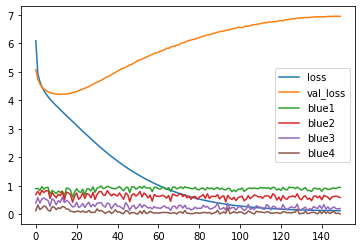

In [19]:
from matplotlib import pyplot as plt

l = len(history.history["loss"])
plt.plot(np.arange(l), history.history["loss"], label = "loss")
plt.plot(np.arange(l), history.history["val_loss"], label = "val_loss")
plt.plot(np.arange(l), model_checkpoint_callback.bleu1, label = "blue1")
plt.plot(np.arange(l), model_checkpoint_callback.bleu2, label = "blue2")
plt.plot(np.arange(l), model_checkpoint_callback.bleu3, label = "blue3")
plt.plot(np.arange(l), model_checkpoint_callback.bleu4, label = "blue4")
plt.legend()
plt.show()

In [23]:
blue4 = np.array(model_checkpoint_callback.bleu1) + np.array(model_checkpoint_callback.bleu2) + np.array(model_checkpoint_callback.bleu3) + np.array(model_checkpoint_callback.bleu4)
blue4 = blue4/4

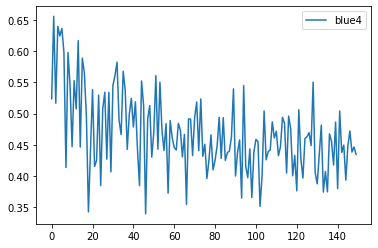

In [25]:
plt.plot(np.arange(l), blue4, label = "blue4")
plt.legend()
plt.show()

# generate 3 texts for every model 

In [10]:
import random
import os 
def randcontext(text,lensen):
    gentrainwords = text.split(" ")
    ran = len(gentrainwords)-lensen
    x = random.randint(0,ran)
    text = " ".join(gentrainwords[x:(x+lensen)])
    return text

In [15]:
def generateText(model,tokenizer,context, t = 0.7, p = 0.9, k = 0):
    prompt = context
    inputs = tokenizer(prompt, add_special_tokens=False, return_tensors="tf")["input_ids"]
    outputs = model.generate(
        max_length=130, 
        do_sample=True,
        temperature=t,
        top_p = p,
        top_k = k
    )
    generated = prompt + tokenizer.decode(outputs[0][1:])
    return generated

In [12]:
def save_to_file(string, path):
    with open(path, 'w') as output_file:
        output_file.write(string)

In [13]:
for filename in os.listdir("generators/gpt2-small"):
    path = "generators/gpt2-small/"+filename
    model = TFAutoModelForCausalLM.from_pretrained(path)
    for i in range(30):
        context = randcontext(wholetext,4)
        string = generateText(model,tokenizer,context)
        save_path = "generators/texts/"+filename + " " + str(i)+ " " + ".txt"
        save_to_file(string,save_path)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at generators/gpt2-small/GPT_2 0.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
All model ch

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at generators/gpt2-small/GPT_2 62.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
Setting `pad_token_id` to 50256 (first `eo

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at generators/gpt2-small/GPT_2 8.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at generators/gpt2-small/GPT_2 92.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eo

In [19]:
## text generation for sampling 


temp = [0.2,0.4,0.6,0.8,1]
k = [5,10,20,50]
p = [0.2,0.6,0.8,1.0]

results = []

model = TFAutoModelForCausalLM.from_pretrained("generators/gpt2-small/GPT_2 6")
for t in temp:
    for ki in k:
        for pi in p:
            print(t,ki,pi)
            filename = "gpt2 " + str((t, ki, pi))
            for i in range(10):
                context = randcontext(wholetext,4)
                string = generateText(model,tokenizer,context, t = t, p = pi, k = ki)
                save_path = "generators/texts_sampling/"+filename + " " + str(i)+ " " + ".txt"
                save_to_file(string,save_path)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at generators/gpt2-small/GPT_2 6.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.2 5 0.2


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.2 5 0.6


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.2 5 0.8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.2 5 1.0


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.2 10 0.2


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.2 10 0.6


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.2 10 0.8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.2 10 1.0


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.2 20 0.2


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.2 20 0.6


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.2 20 0.8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.2 20 1.0


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.2 50 0.2


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.2 50 0.6


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.2 50 0.8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.2 50 1.0


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.4 5 0.2


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.4 5 0.6


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.4 5 0.8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.4 5 1.0


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.4 10 0.2


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.4 10 0.6


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.4 10 0.8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.4 10 1.0


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.4 20 0.2


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.4 20 0.6


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.4 20 0.8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.4 20 1.0


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.4 50 0.2


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.4 50 0.6


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.4 50 0.8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.4 50 1.0


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.6 5 0.2


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.6 5 0.6


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.6 5 0.8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.6 5 1.0


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.6 10 0.2


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.6 10 0.6


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.6 10 0.8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.6 10 1.0


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.6 20 0.2


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.6 20 0.6


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.6 20 0.8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.6 20 1.0


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.6 50 0.2


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.6 50 0.6


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.6 50 0.8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.6 50 1.0


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.8 5 0.2


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.8 5 0.6


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.8 5 0.8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.8 5 1.0


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.8 10 0.2


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.8 10 0.6


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.8 10 0.8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.8 10 1.0


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.8 20 0.2


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.8 20 0.6


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.8 20 0.8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.8 20 1.0


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.8 50 0.2


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.8 50 0.6


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.8 50 0.8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.8 50 1.0


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


1 5 0.2


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


1 5 0.6


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


1 5 0.8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


1 5 1.0


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


1 10 0.2


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


1 10 0.6


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


1 10 0.8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


1 10 1.0


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


1 20 0.2


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


1 20 0.6


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


1 20 0.8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


1 20 1.0


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


1 50 0.2


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


1 50 0.6


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


1 50 0.8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


1 50 1.0


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


## maximum score after tuning is 0.7967595377757754, 
 best parameters: 
- temperature = 0.6 
- top-k = 50
- top-p = 1

In [20]:
for i in range(100):
    filename = "gpt2_0.6_50_1"
    context = randcontext(wholetext,4)
    string = generateText(model,tokenizer,context, t = 0.6, p = 1, k = 50)
    save_path = "generators/GPT2_text_best/"+filename + " " + str(i)+ " " + ".txt"
    save_to_file(string,save_path)

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad